<a href="https://colab.research.google.com/github/haoboooo/Temporal-Generalization-of-Sentiment-Analysis-on-Amazon-Reviews/blob/main/amazon_fashion/fashion_merge_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install emoji library
!pip install emot

     |████████████████████████████████| 61 kB 24 kB/s 


In [ ]:
import pandas as pd
import numpy as np
import string
import os

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score, f1_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model

from tensorflow.keras.layers import Input,Embedding,Bidirectional,LSTM,BatchNormalization,Dense,GlobalMaxPool1D,Dropout,Masking,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential,load_model

In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

print(tf.test.is_built_with_cuda())
print(tf.keras.__version__)
print(tf.__version__)

Default GPU Device: /device:GPU:0
True
2.8.0
2.8.0


In [ ]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## load fashion data

In [ ]:
file1 = "./drive/MyDrive/Colab Notebooks/CL/fashion/02_06.csv"
file2 = "./drive/MyDrive/Colab Notebooks/CL/fashion/07_12.csv"
file3 = "./drive/MyDrive/Colab Notebooks/CL/fashion/13_17.csv"
file4 = "./drive/MyDrive/Colab Notebooks/CL/fashion/18.csv"

In [ ]:
def load_data(file):
  # read csv data and set columns
  df = pd.read_csv(file,usecols=['overall', 'reviewTime','reviewText'])

  # remove the duplicates if any
  df.duplicated('reviewText').sum()
  df.drop_duplicates(subset=['reviewText'],inplace=True)
  
  # remove NaN rows
  df.isnull().sum()
  df.dropna(how='any',axis=0,inplace=True)
  shape = df.shape
  counts = df.overall.value_counts()# labels count

  sns.countplot(df['overall']) # plot bar graph
  fig = plt.gcf() # get current figure
  fig.set_size_inches(5,5) # set the figure size
  plt.title('overall') # add title to the figure

  return df,shape,counts

(530, 3)
 1.0    386
-1.0     98
 0.0     46
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2006,This China Silk Black Balaclava is great for k...
1,1.0,2004,This item is very lightweight (as you'd expect...
2,1.0,2006,This item came in only 2 days and in perfect c...
3,1.0,2006,This ring was well worth the price. It has a l...
4,1.0,2006,"It was exactly as described. Beautiful ring, ..."


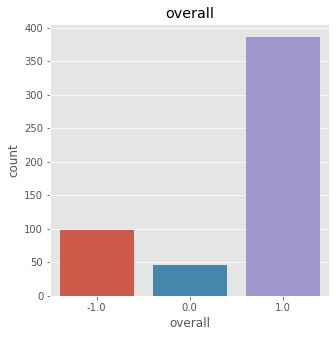

In [ ]:
# load data for 2002 - 2006
df1,shape1,counts1 = load_data(file1)
print(shape1)
print(counts1)
df1.head()

(16800, 3)
 1.0    12574
-1.0     2657
 0.0     1569
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,-1.0,2012,"I ordered a ladies cigarette case for my wife,..."
1,1.0,2010,Received the case in less than a week...was ve...
2,-1.0,2012,Don't buy this shirt unless you plan to spend ...
3,1.0,2012,"Nice shirt, Well made. good sizing. Nice color..."
4,1.0,2011,If you want a look that takes it back to the O...


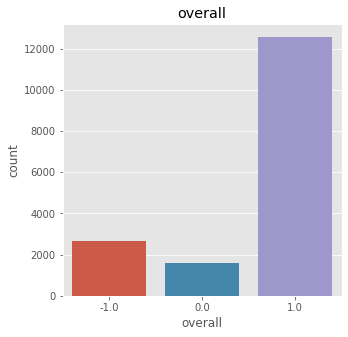

In [ ]:
# load data for 2007 - 2012
df2,shape2,counts2 = load_data(file2)
print(shape2)
print(counts2)
df2.head()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(614812, 3)
 1.0    413534
-1.0    130175
 0.0     71103
Name: overall, dtype: int64


,overall,reviewTime,reviewText
0,1.0,2014,Exactly what I needed.
1,-1.0,2014,"I agree with the other review, the opening is ..."
2,1.0,2014,Love these... I am going to order another pack...
3,-1.0,2014,too tiny an opening
4,0.0,2014,Okay


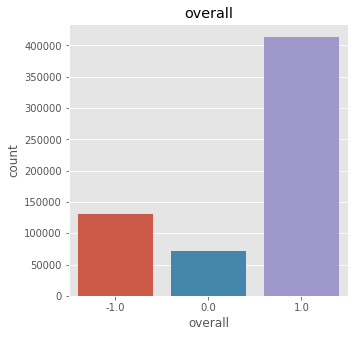

In [ ]:
# load data for 2013 - 2017
df3,shape3,counts3 = load_data(file3)
print(shape3)
print(counts3)
df3.head()

(47246, 3)
 1.0    33622
-1.0     8865
 0.0     4759
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2018,Just what I needed for a party
1,1.0,2018,Son loves it. Decent quality.
2,1.0,2018,My son wanted to dress like August Pullman fro...
3,1.0,2018,awesome.
4,1.0,2018,My daughter loves this item. My high score is ...


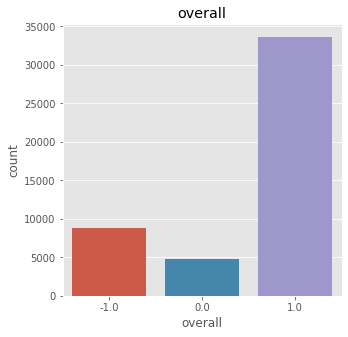

In [ ]:
# load data for 2018
df4,shape4,counts4 = load_data(file4)
print(shape4)
print(counts4)
df4.head()

## Split and Balance train&test

Balance each time period for 
6000 positive，2500 negative，1500 neutral except 2002-2006

80%(8000) training and 20%(2000) testing

In [ ]:
def split_balance(df):
  # get data of each class
  groups = df.groupby(df.overall)
  pos = groups.get_group(1)
  neu = groups.get_group(0)
  neg = groups.get_group(-1)

  # shuffle the dataframe
  pos = pos.sample(frac=1.0)
  neu = neu.sample(frac=1.0)
  neg = neg.sample(frac=1.0)

  # split to get train for each class
  train_posdata = pos.iloc[:4800,:]
  train_neudata = neu.iloc[:1200,:]
  train_negdata = neg.iloc[:2000,:]

  # split to get test for each class
  test_posdata = pos.iloc[4800:6000,:]
  test_neudata = neu.iloc[1200:1500,:]
  test_negdata = neg.iloc[2000:2500,:]

  train = pd.concat([train_posdata, train_neudata, train_negdata],sort=False).sample(frac=1.0)
  test = pd.concat([test_posdata, test_neudata, test_negdata],sort=False).sample(frac=1.0)

  return train,test

In [ ]:
# No data for 2002 - 2006
# df1_train,df1_test = split_balance(df1)

# data for 2007 - 2012
df1_train,df1_test = split_balance(df2)

# data for 2013 - 2017
df2_train,df2_test = split_balance(df3)

# data for 2018
df3_train,df3_test = split_balance(df4)

In [ ]:
df1_train["overall"] = df1_train["overall"].replace(-1,2)
df1_test["overall"] = df1_test["overall"].replace(-1,2)

df2_train["overall"] = df2_train["overall"].replace(-1,2)
df2_test["overall"] = df2_test["overall"].replace(-1,2)

df3_train["overall"] = df3_train["overall"].replace(-1,2)
df3_test["overall"] = df3_test["overall"].replace(-1,2)

In [ ]:
df1_train.head()

,overall,reviewTime,reviewText
16359,1.0,2010,The bracelet is beautiful but I took a chance ...
14558,1.0,2012,I love love these leggings I was worried they ...
10425,1.0,2010,It's a beautiful watch with very good quality....
12146,1.0,2009,It is exactly what it claims to be. I wear it...
15806,2.0,2007,The picture of the necklace makes it appear mu...


## Text Preprocessing

In [ ]:
# get stopwords from txt
def get_stop_words(txt):
    #read the stop words
    with open(txt,'r') as f:
        stopwords_list=f.readlines()
    for i in range (0,len(stopwords_list)):
        stopwords_list[i]=stopwords_list[i].replace('\n','')
    return stopwords_list

In [ ]:
# Defining my NLTK stop words and my user-defined stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase) # 26 letters with lowercase
user_stop_words = get_stop_words("./drive/MyDrive/Colab Notebooks/CL/stopwords.txt")
stop_words = stop_words+alphabets+user_stop_words
emojis = {**UNICODE_EMOJI,**EMOTICONS_EMO} # full list of emojis unicodes

In [ ]:
def processtext(txt):
  # replace all emojis
  for emo in emojis.keys():
    txt = txt.replace(emo,"EMOJI "+emojis[emo])
  
  txt = txt.replace('\r', '').replace('\n', ' ')
  # remove all html tag
  txt = re.sub("(<.*?>)", "", txt)
  # remove all urls
  txt = re.sub('https?:\/\/\S+','',txt)
  # remove @ references  
  txt = re.sub('@[\w_]+','',txt)
  # remove # hashtags
  txt = re.sub('#\S+','',txt)
  # replace digits with no space
  txt = re.sub(r"\d", '',txt)
  # convert tweet to lower case
  txt = txt.lower()
  # remove all multiple white spaces
  txt = re.sub('[\s]+',' ',txt)
  # remove all punctuations and non-ascii
  txt = re.sub('[\.?!,;:\-\[\]\{\}\(\)\'\"/]','',txt)
  txt = txt.replace('$','').replace('&','')
  # remove whitespace
  txt = txt.strip()

  tokens = word_tokenize(txt)
  filtered_words = [w for w in tokens if w not in stop_words]
  # filtered_words = [w for w in filtered_words if w in word_list]
  return " ".join(filtered_words)

In [ ]:
df1_train["cleanText"] = df1_train["reviewText"].apply(processtext)
df1_test["cleanText"] = df1_test["reviewText"].apply(processtext)

df2_train["cleanText"] = df2_train["reviewText"].apply(processtext)
df2_test["cleanText"] = df2_test["reviewText"].apply(processtext)

df3_train["cleanText"] = df3_train["reviewText"].apply(processtext)
df3_test["cleanText"] = df3_test["reviewText"].apply(processtext)

In [ ]:
df1_train.head()

,overall,reviewTime,reviewText,cleanText
16359,1.0,2010,The bracelet is beautiful but I took a chance ...,bracelet beautiful took chance ordering length...
14558,1.0,2012,I love love these leggings I was worried they ...,love love leggings worried going fit short len...
10425,1.0,2010,It's a beautiful watch with very good quality....,beautiful watch good quality gave stars leathe...
12146,1.0,2009,It is exactly what it claims to be. I wear it...,exactly claims wear time griefs purchasing
15806,2.0,2007,The picture of the necklace makes it appear mu...,picture necklace makes appear much thicker kno...


## Merge train&test data

Extract 33% data from each time period and combine train&test

In [ ]:
def merge(df1,df2,df3,rate):
  sample1 = df1.sample(frac=rate,replace=False,random_state=None,axis=0) # sample frac rate of rows from the dataframe without replacement
  sample2 = df2.sample(frac=rate,replace=False,random_state=None,axis=0)
  sample3 = df3.sample(frac=rate,replace=False,random_state=None,axis=0)

  merged = pd.concat([sample1, sample2, sample3],sort=False).sample(frac=1.0)

  return merged

In [ ]:
train_merged = merge(df1_train,df2_train,df3_train,0.33)
test_merged = merge(df1_test,df2_test,df3_test,0.33)

In [ ]:
train_merged.shape

(7920, 4)

In [ ]:
test_merged.shape

(1980, 4)

## Text Tokenization

In [ ]:
def tokenize(data1,data2):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(data1)
  print(f"{len(tokenizer.word_index)} words are used")

  vocab_size=len(tokenizer.word_index)
  tokenizer = Tokenizer(num_words=vocab_size)

  tokenizer.fit_on_texts(data1)
  train_fea = tokenizer.texts_to_sequences(data1)
  test_fea = tokenizer.texts_to_sequences(data2)

  length_tr = [len(s) for s in train_fea]
  print("Training:")
  print(f"Average length of each row >> {np.mean(length_tr)}")
  print(f"Maximum length of each row >> {np.max(length_tr)}")
  plt.hist(length_tr,bins=50)
  plt.show()

  length_te = [len(s) for s in test_fea]
  print("Testing")
  print(f"Average length of each row >> {np.mean(length_te)}")
  print(f"Maximum length of each row >> {np.max(length_te)}")
  plt.hist(length_te,bins=50)
  plt.show()

  seq_len = max(max(length_tr),max(length_te))
  print("max sequence length: ",seq_len)

  return train_fea,test_fea,vocab_size,seq_len

16377 words are used
Training:
Average length of each row >> 27.786875
Maximum length of each row >> 571


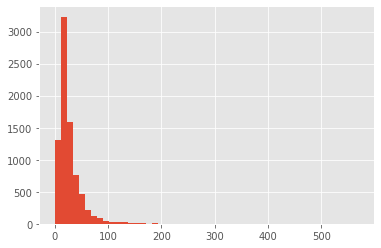

Testing
Average length of each row >> 25.857
Maximum length of each row >> 205


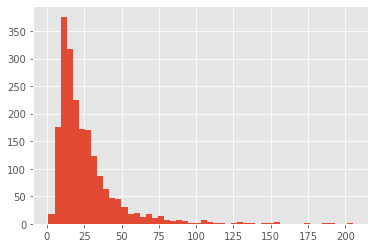

max sequence length:  571


In [ ]:
df1_train_fea,df1_test_fea,df1_vocab_size,df1_maxlen = tokenize(df1_train["cleanText"],df1_test["cleanText"])

9627 words are used
Training:
Average length of each row >> 14.505625
Maximum length of each row >> 252


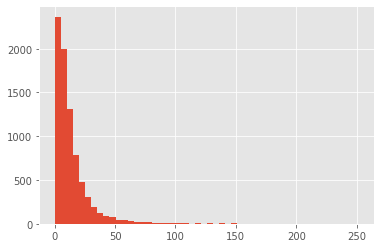

Testing
Average length of each row >> 13.735
Maximum length of each row >> 173


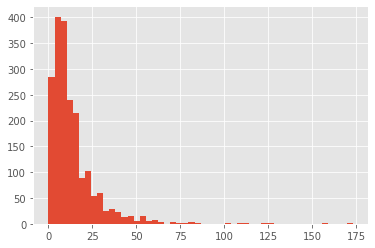

max sequence length:  252


In [ ]:
df2_train_fea,df2_test_fea,df2_vocab_size,df2_maxlen = tokenize(df2_train["cleanText"],df2_test["cleanText"])

8941 words are used
Training:
Average length of each row >> 12.433
Maximum length of each row >> 530


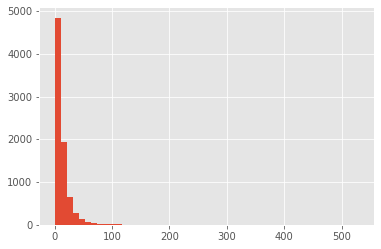

Testing
Average length of each row >> 11.4315
Maximum length of each row >> 191


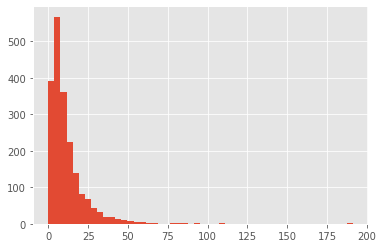

max sequence length:  530


In [ ]:
df3_train_fea,df3_test_fea,df3_vocab_size,df3_maxlen = tokenize(df3_train["cleanText"],df3_test["cleanText"])

11920 words are used
Training:
Average length of each row >> 18.007323232323234
Maximum length of each row >> 332


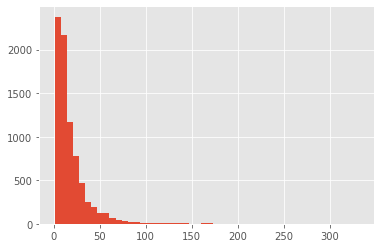

Testing
Average length of each row >> 16.93232323232323
Maximum length of each row >> 199


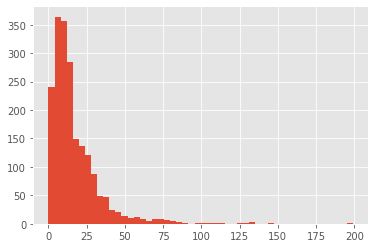

max sequence length:  332


In [ ]:
merge_train_fea,merge_test_fea,merge_vocab_size,merge_maxlen = tokenize(train_merged["cleanText"],test_merged["cleanText"])

## Padding

In [ ]:
sequence_size = max(df1_maxlen,df2_maxlen,df3_maxlen,merge_maxlen)
print("max sequence length for software: ",sequence_size)

max sequence length for software:  571


In [ ]:
df1_train_pad = pad_sequences(df1_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_test_pad = pad_sequences(df1_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_train_label = to_categorical(df1_train.overall,num_classes=3)
df1_test_label = to_categorical(df1_test.overall,num_classes=3)

df2_train_pad = pad_sequences(df2_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_test_pad = pad_sequences(df2_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_train_label = to_categorical(df2_train.overall,num_classes=3)
df2_test_label = to_categorical(df2_test.overall,num_classes=3)

df3_train_pad = pad_sequences(df3_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_test_pad = pad_sequences(df3_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_train_label = to_categorical(df3_train.overall,num_classes=3)
df3_test_label = to_categorical(df3_test.overall,num_classes=3)

merge_train_pad = pad_sequences(merge_train_fea,maxlen=sequence_size,padding='post',truncating='post')
merge_test_pad = pad_sequences(merge_test_fea,maxlen=sequence_size,padding='post',truncating='post')
merge_train_label = to_categorical(train_merged.overall,num_classes=3)
merge_test_label = to_categorical(test_merged.overall,num_classes=3)

## Build LSTM Model and Train on merged train

In [ ]:
# hyperparameters
word_vec_size = 100
hidden_size = 128
batch_size = 128
epochs = 8
vocab_size = max(df1_vocab_size,df2_vocab_size,df3_vocab_size,merge_vocab_size)
print("max vocab size: ",vocab_size)

max vocab size:  16377


In [ ]:
def bilstm_model():
    model = Sequential()
    model.add(Input(shape=[sequence_size]))
    model.add(Embedding(vocab_size,word_vec_size,input_length=sequence_size))
    model.add(Bidirectional(LSTM(hidden_size,return_sequences=True)))
    model.add(Flatten())
    model.output_shape
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
es = EarlyStopping(monitor='val_accuracy',mode='min',patience=4,verbose=1)

In [ ]:
bilstm = bilstm_model()
plot_model(bilstm)
lstm_no_hist = bilstm.fit(merge_train_pad,merge_train_label,epochs=epochs,batch_size=batch_size,validation_data=(merge_test_pad,merge_test_label),callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 571, 100)          1637700   
                                                                 
 bidirectional (Bidirectiona  (None, 571, 256)         234496    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 146176)            0         
                                                                 
 dense (Dense)               (None, 32)                4677664   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                        

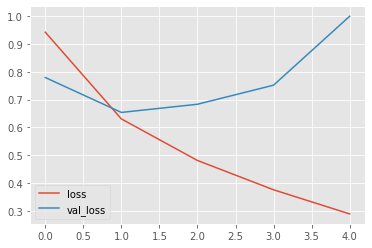

In [ ]:
plt.plot(lstm_no_hist.history['loss'], label='loss')
plt.plot(lstm_no_hist.history['val_loss'], label = 'val_loss')
plt.legend()

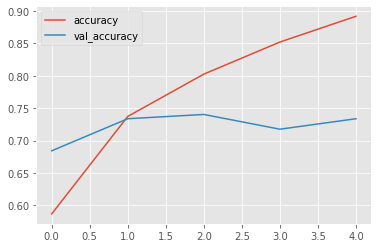

In [ ]:
plt.plot(lstm_no_hist.history['accuracy'], label= 'accuracy')
plt.plot(lstm_no_hist.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
bilstm.save('./drive/MyDrive/Colab Notebooks/CL/fashion/LSTM/BiLSTM_merge.h5')

## Evaluate on each time period data

In [ ]:
merge_bilstm = load_model('./drive/MyDrive/Colab Notebooks/CL/fashion/LSTM/BiLSTM_merge.h5')
merge_bilstm.evaluate(df1_test_pad,df1_test_label)

63/63 [==============================] - 4s 38ms/step - loss: 3.0478 - accuracy: 0.4825


[3.047780990600586, 0.48249998688697815]

In [ ]:
merge_bilstm = load_model('./drive/MyDrive/Colab Notebooks/CL/fashion/LSTM/BiLSTM_merge.h5')
merge_bilstm.evaluate(df2_test_pad,df2_test_label)

63/63 [==============================] - 2s 23ms/step - loss: 2.2983 - accuracy: 0.5060


[2.2982585430145264, 0.5059999823570251]

In [ ]:
merge_bilstm = load_model('./drive/MyDrive/Colab Notebooks/CL/fashion/LSTM/BiLSTM_merge.h5')
merge_bilstm.evaluate(df3_test_pad,df3_test_label)

63/63 [==============================] - 2s 23ms/step - loss: 1.8749 - accuracy: 0.5490


[1.87490975856781, 0.5490000247955322]

## Fine tune on 2007-2012

8963 words are used
Training:
Average length of each row >> 28.243560606060605
Maximum length of each row >> 571


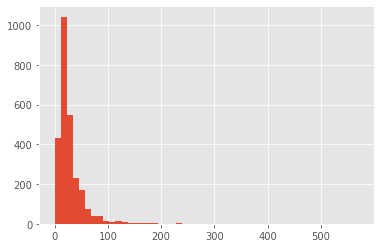

Testing
Average length of each row >> 24.283333333333335
Maximum length of each row >> 194


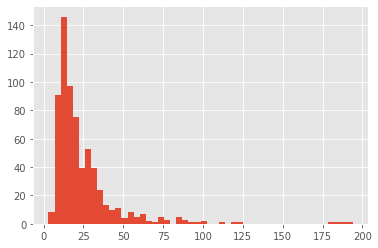

max sequence length:  571


In [ ]:
merged_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/fashion/LSTM/BiLSTM_merge.h5')

df1_sample_train = df1_train.sample(frac=0.33,replace=False,random_state=None,axis=0)
df1_sample_test = df1_test.sample(frac=0.33,replace=False,random_state=None,axis=0)

df1_sample_train_fea,df1_sample_test_fea,df1_sample_vocab_size,df1_sample_maxlen = tokenize(df1_sample_train["cleanText"],df1_sample_test["cleanText"])

In [ ]:
df1_sample_train_pad = pad_sequences(df1_sample_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_sample_test_pad = pad_sequences(df1_sample_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_sample_train_label = to_categorical(df1_sample_train.overall,num_classes=3)
df1_sample_test_label = to_categorical(df1_sample_test.overall,num_classes=3)

In [ ]:
merged_lstm.fit(df1_sample_train_pad,df1_sample_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df1_sample_test_pad,df1_sample_test_label),callbacks=[es])

Epoch 1/8
21/21 [==============================] - 5s 134ms/step - loss: 1.2185 - accuracy: 0.4917 - val_loss: 0.9643 - val_accuracy: 0.5742
Epoch 2/8
21/21 [==============================] - 2s 95ms/step - loss: 0.9362 - accuracy: 0.5814 - val_loss: 0.9777 - val_accuracy: 0.5742
Epoch 3/8
21/21 [==============================] - 2s 95ms/step - loss: 0.8508 - accuracy: 0.5928 - val_loss: 0.8639 - val_accuracy: 0.5742
Epoch 4/8
21/21 [==============================] - 2s 96ms/step - loss: 0.6168 - accuracy: 0.6951 - val_loss: 0.8696 - val_accuracy: 0.7045
Epoch 5/8
21/21 [==============================] - 2s 96ms/step - loss: 0.4065 - accuracy: 0.8152 - val_loss: 1.1854 - val_accuracy: 0.6955
Epoch 5: early stopping


## Fine tune on 2013-2017

5397 words are used
Training:
Average length of each row >> 14.339015151515152
Maximum length of each row >> 252


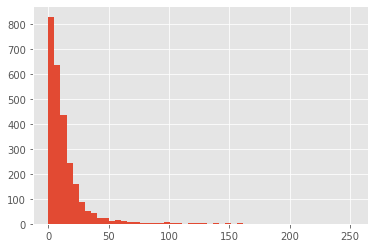

Testing
Average length of each row >> 13.006060606060606
Maximum length of each row >> 119


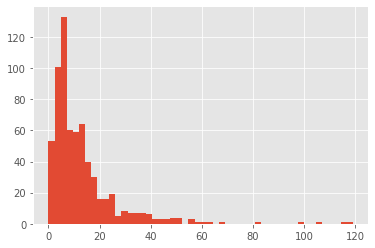

max sequence length:  252


In [ ]:
merged_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/fashion/LSTM/BiLSTM_merge.h5')

df2_sample_train = df2_train.sample(frac=0.33,replace=False,random_state=None,axis=0)
df2_sample_test = df2_test.sample(frac=0.33,replace=False,random_state=None,axis=0)

df2_sample_train_fea,df2_sample_test_fea,df2_sample_vocab_size,df2_sample_maxlen = tokenize(df2_sample_train["cleanText"],df2_sample_test["cleanText"])

In [ ]:
df2_sample_train_pad = pad_sequences(df2_sample_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_sample_test_pad = pad_sequences(df2_sample_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_sample_train_label = to_categorical(df2_sample_train.overall,num_classes=3)
df2_sample_test_label = to_categorical(df2_sample_test.overall,num_classes=3)

In [ ]:
merged_lstm.fit(df2_sample_train_pad,df2_sample_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df2_sample_test_pad,df2_sample_test_label),callbacks=[es])

Epoch 1/8
21/21 [==============================] - 4s 132ms/step - loss: 1.0551 - accuracy: 0.5697 - val_loss: 0.9035 - val_accuracy: 0.5985
Epoch 2/8
21/21 [==============================] - 2s 95ms/step - loss: 0.8575 - accuracy: 0.6167 - val_loss: 0.8500 - val_accuracy: 0.6273
Epoch 3/8
21/21 [==============================] - 2s 94ms/step - loss: 0.7473 - accuracy: 0.6765 - val_loss: 0.8260 - val_accuracy: 0.6561
Epoch 4/8
21/21 [==============================] - 2s 94ms/step - loss: 0.6214 - accuracy: 0.7386 - val_loss: 0.7804 - val_accuracy: 0.6909
Epoch 5/8
21/21 [==============================] - 2s 95ms/step - loss: 0.4751 - accuracy: 0.8011 - val_loss: 0.8375 - val_accuracy: 0.7227
Epoch 5: early stopping


## Fine tune on 2018

5039 words are used
Training:
Average length of each row >> 12.661363636363637
Maximum length of each row >> 530


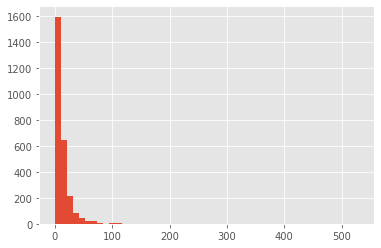

Testing
Average length of each row >> 10.913636363636364
Maximum length of each row >> 92


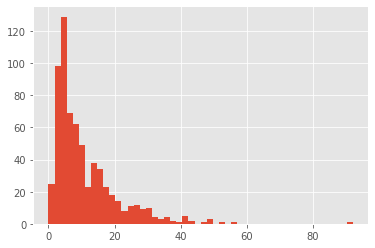

max sequence length:  530


In [ ]:
merged_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/fashion/LSTM/BiLSTM_merge.h5')

df3_sample_train = df3_train.sample(frac=0.33,replace=False,random_state=None,axis=0)
df3_sample_test = df3_test.sample(frac=0.33,replace=False,random_state=None,axis=0)

df3_sample_train_fea,df3_sample_test_fea,df3_sample_vocab_size,df3_sample_maxlen = tokenize(df3_sample_train["cleanText"],df3_sample_test["cleanText"])

In [ ]:
df3_sample_train_pad = pad_sequences(df3_sample_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_sample_test_pad = pad_sequences(df3_sample_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_sample_train_label = to_categorical(df3_sample_train.overall,num_classes=3)
df3_sample_test_label = to_categorical(df3_sample_test.overall,num_classes=3)

In [ ]:
merged_lstm.fit(df3_sample_train_pad,df3_sample_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df3_sample_test_pad,df3_sample_test_label),callbacks=[es])

Epoch 1/8
21/21 [==============================] - 4s 133ms/step - loss: 1.0684 - accuracy: 0.5686 - val_loss: 0.9054 - val_accuracy: 0.6030
Epoch 2/8
21/21 [==============================] - 2s 94ms/step - loss: 0.9066 - accuracy: 0.6023 - val_loss: 0.8787 - val_accuracy: 0.6030
Epoch 3/8
21/21 [==============================] - 2s 95ms/step - loss: 0.7971 - accuracy: 0.6492 - val_loss: 0.8261 - val_accuracy: 0.6636
Epoch 4/8
21/21 [==============================] - 2s 96ms/step - loss: 0.6408 - accuracy: 0.7189 - val_loss: 0.8475 - val_accuracy: 0.6894
Epoch 5/8
21/21 [==============================] - 2s 96ms/step - loss: 0.4591 - accuracy: 0.8034 - val_loss: 0.7927 - val_accuracy: 0.6909
Epoch 5: early stopping
